In [34]:
!pip install contractions

In [35]:
import pandas as pd
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler, ADASYN
from imblearn.under_sampling import EditedNearestNeighbours
import contractions
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

In [36]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [37]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [38]:
# 1. Load dataset (adjust path or loader as needed)
df = pd.read_csv('/content/tweet_emotions.csv')

In [39]:
df

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
...,...,...,...
39995,1753918954,neutral,@JohnLloydTaylor
39996,1753919001,love,Happy Mothers Day All my love
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [40]:
df = df.drop('tweet_id', axis=1)

In [41]:
df

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...
...,...,...
39995,neutral,@JohnLloydTaylor
39996,love,Happy Mothers Day All my love
39997,love,Happy Mother's Day to all the mommies out ther...
39998,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


/tmp/ipython-input-3704564102.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='sentiment', order = df['sentiment'].value_counts().index, palette='viridis')


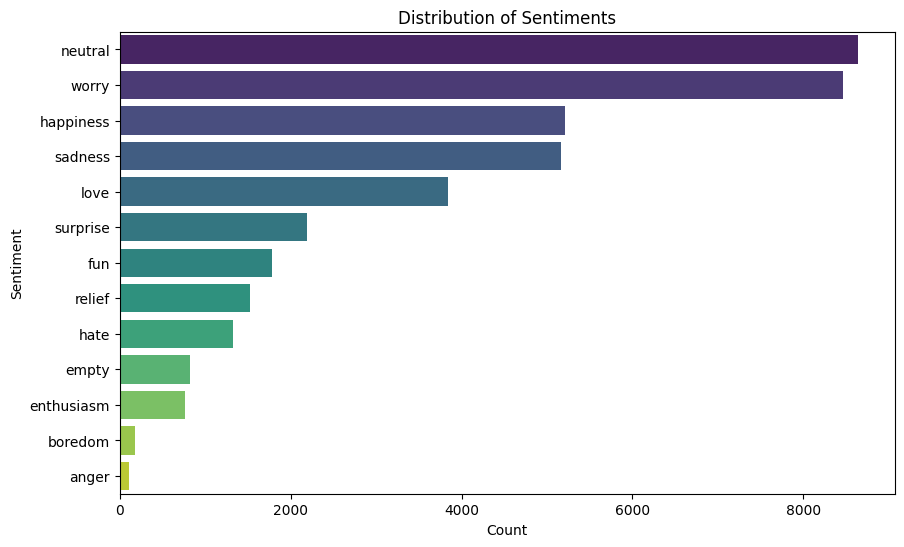

In [42]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='sentiment', order = df['sentiment'].value_counts().index, palette='viridis')
plt.title('Distribution of Sentiments')
plt.xlabel('Count')
plt.ylabel('Sentiment')
plt.show()

In [43]:
# 2. Filter top 4 classes
label_col = 'label' if 'label' in df.columns else 'sentiment'

top_classes = df[label_col].value_counts().nlargest(4).index.tolist()
df_top4 = df[df[label_col].isin(top_classes)].copy()

/tmp/ipython-input-3886820647.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_top4, y=label_col, order=df_top4[label_col].value_counts().index, palette='viridis')


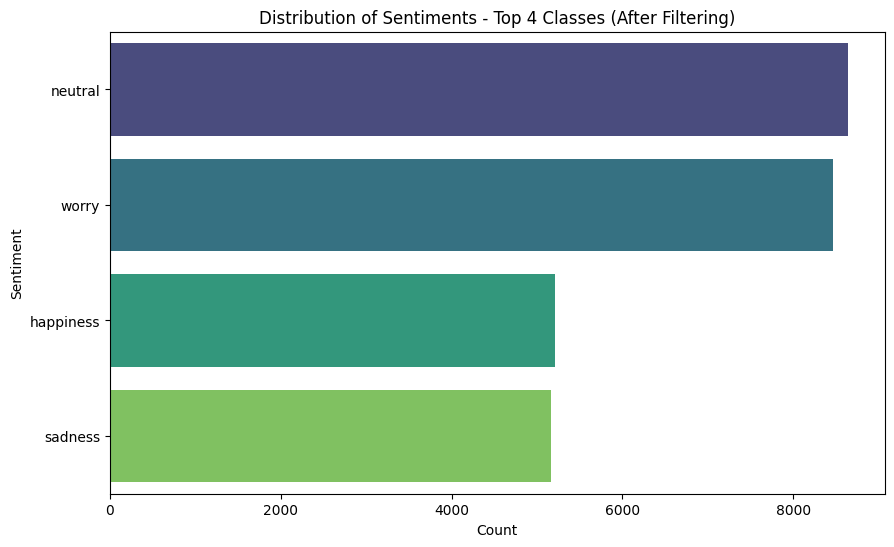

In [44]:
# Plot 2: Distribution after filtering top 4 classes
plt.figure(figsize=(10, 6))
sns.countplot(data=df_top4, y=label_col, order=df_top4[label_col].value_counts().index, palette='viridis')
plt.title('Distribution of Sentiments - Top 4 Classes (After Filtering)')
plt.xlabel('Count')
plt.ylabel('Sentiment')
plt.show()

In [45]:
# Optional sampling to reduce data size (comment out if full dataset is needed)
df = df.sample(frac=1, random_state=42)
df_top4 = df_top4[df_top4.index.isin(df.index)]

In [46]:
# 3. Preprocessing function
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = contractions.fix(text)
    text = re.sub(r'\d+', 'NUM', text)
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t.isascii()]
    return ' '.join(tokens)

df_top4['content'] = df_top4['content'].apply(preprocess)

In [47]:
# 4. Train-test split on filtered & preprocessed data
X_train, X_test, y_train, y_test = train_test_split(
    df_top4['content'], df_top4[label_col], test_size=0.2, stratify=df_top4[label_col], random_state=42
)

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [51]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

In [52]:
# 5. Vectorizer and model setup
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english', min_df=5, max_df=0.8)
rf_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

In [53]:
# 6. Pipeline with balancing and classifier
pipeline_rf = ImbPipeline([
    ('vectorizer', vectorizer),
    ('ros', RandomOverSampler(random_state=42)),
    ('adasyn', ADASYN(random_state=42)),
    ('enn', EditedNearestNeighbours()),
    ('clf', rf_model)
])

In [54]:
# 7. Stratified K-Fold Cross-Validation for model evaluation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline_rf, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
print(f"Random Forest CV accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

Random Forest CV accuracy: 0.2717 ± 0.0273


In [55]:
# 8. Fit pipeline on full training data and evaluate on test data
pipeline_rf.fit(X_train, y_train)
acc_test_rf = pipeline_rf.score(X_test, y_test)
print(f"Random Forest test accuracy: {acc_test_rf:.4f}")

Random Forest test accuracy: 0.2553


In [56]:
# 9. Classification report on test set
from sklearn.metrics import classification_report
y_pred = pipeline_rf.predict(X_test)
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred))

Classification Report (Test Set):
              precision    recall  f1-score   support

   happiness       0.22      0.95      0.36      1042
     neutral       0.46      0.06      0.11      1728
     sadness       0.42      0.24      0.31      1033
       worry       0.47      0.03      0.06      1692

    accuracy                           0.26      5495
   macro avg       0.39      0.32      0.21      5495
weighted avg       0.41      0.26      0.18      5495



In [57]:
from sklearn.svm import LinearSVC

In [58]:
# Define vectorizer and classifier
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english', min_df=5, max_df=0.8)
svm_model = LinearSVC(random_state=42)

In [59]:
# Build pipeline with RandomOverSampler (simple balancing)
pipeline_svm = ImbPipeline([
    ('vectorizer', vectorizer),
    ('ros', RandomOverSampler(random_state=42)),
    ('clf', svm_model)
])

In [60]:
# Stratified K-Fold CV
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scores = cross_val_score(pipeline_svm, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
print(f"SVM CV accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

SVM CV accuracy: 0.4185 ± 0.0026


In [61]:
# Fit on full training data and evaluate on test set
pipeline_svm.fit(X_train, y_train)
acc_test = pipeline_svm.score(X_test, y_test)
print(f"SVM test accuracy: {acc_test:.4f}")

SVM test accuracy: 0.4246


In [62]:
# Classification report
y_pred = pipeline_svm.predict(X_test)
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred))

Classification Report (Test Set):
              precision    recall  f1-score   support

   happiness       0.42      0.54      0.47      1042
     neutral       0.47      0.45      0.46      1728
     sadness       0.33      0.39      0.36      1033
       worry       0.45      0.35      0.40      1692

    accuracy                           0.42      5495
   macro avg       0.42      0.43      0.42      5495
weighted avg       0.43      0.42      0.42      5495



In [63]:
from sklearn.linear_model import LogisticRegression

In [64]:
# Vectorizer and classifier
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english', min_df=5, max_df=0.8)
lr_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)

In [65]:
# Pipeline with balancing
pipeline_lr = ImbPipeline([
    ('vectorizer', vectorizer),
    ('ros', RandomOverSampler(random_state=42)),
    ('clf', lr_model)
])

In [66]:
# Stratified K-Fold CV
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scores = cross_val_score(pipeline_lr, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
print(f"Logistic Regression CV accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

Logistic Regression CV accuracy: 0.4354 ± 0.0056


In [67]:
# Fit and evaluate on test set
pipeline_lr.fit(X_train, y_train)
acc_test = pipeline_lr.score(X_test, y_test)
print(f"Logistic Regression test accuracy: {acc_test:.4f}")

Logistic Regression test accuracy: 0.4457


In [68]:
# Classification report
y_pred = pipeline_lr.predict(X_test)
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred))

Classification Report (Test Set):
              precision    recall  f1-score   support

   happiness       0.46      0.56      0.51      1042
     neutral       0.49      0.47      0.48      1728
     sadness       0.35      0.41      0.38      1033
       worry       0.46      0.37      0.41      1692

    accuracy                           0.45      5495
   macro avg       0.44      0.45      0.44      5495
weighted avg       0.45      0.45      0.44      5495



In [69]:
# 11. Classification report on training set
y_pred_train = pipeline_lr.predict(X_train)
print("\nClassification Report (Train Set):")
print(classification_report(y_train, y_pred_train))


Classification Report (Train Set):
              precision    recall  f1-score   support

   happiness       0.60      0.74      0.66      4167
     neutral       0.65      0.62      0.63      6910
     sadness       0.54      0.64      0.59      4132
       worry       0.66      0.51      0.58      6767

    accuracy                           0.61     21976
   macro avg       0.61      0.63      0.61     21976
weighted avg       0.62      0.61      0.61     21976

